In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
from sklearn.linear_model import LassoLarsIC
from tqdm import tqdm

##### Load Data

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_28/func_0'

In [3]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 22.08 sec


In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 73.66 ms


In [5]:
unique_stimuli = bbb.get_stimuli(os.path.join(directory,'visual'))

loading photodiode data... done
loading visual stimuli data... done
Successfully parsed all stimuli from photodiode output.


##### Interpolate data

In [6]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
z = 17
x = 2
y = 39

In [7]:
def interp_data(brain, resolution, z, expt_len):
    #resolution is in ms
    interp = interp1d(timestamps[:,z], brain[:,:,z,:], fill_value='extrapolate')
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    y = interp(xnew)
    return xnew, y

In [8]:
timestamps_interp, brain_interp = interp_data(brain,resolution,z,expt_len)

###### Calculate canonical response

In [9]:
# The goal
# First need a vector of 0s, with 1s where onset of stimuli
# Interp brain data to 100ms time points - do same interp on stimuli timing
# Then it is easy!
# Timestamps and stim times are all in ms and correctly aligned. Easy!!!
# Then, with 01 vector, make into toeplitz to calculate canonical response.

In [10]:
def make_01_vector(stimtimes, resolution, expt_len):
    stimtimes01 = np.zeros(int(expt_len/resolution))
    stim_ints = [int(i/resolution) for i in stimtimes]
    stimtimes01[stim_ints] = 1
    return stimtimes01

In [11]:
stimtimes01 = make_01_vector(unique_stimuli[2]['times'], resolution, expt_len)

In [12]:
# Form Toeplitz
beta_len = 30 #in resolution units
num_voxel_to_avg = 9
X = toeplitz(stimtimes01,np.zeros(beta_len))
X = np.tile(X,(num_voxel_to_avg,1))

In [13]:
# Create response vector
Y=[]
for w in range(x,x+3):
    for h in range(y,y+3):
        Y.append(brain_interp[w,h,:])
Y = np.reshape(Y,(np.size(Y)))

# Solve linear algebra
results = sl.lstsq(X, Y)
canonical_resp = results[0]

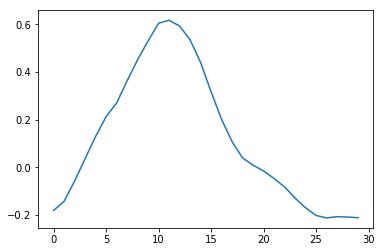

In [14]:
#1 sec on, 2sec off
plt.plot(canonical_resp)
plt.show()

###### Method 1 - Calculate direction betas all in one matrix

In [145]:
stims01 = []
for i in range(len(unique_stimuli)):
    out = make_01_vector(unique_stimuli[i]['times'], resolution, expt_len)
    stims01.append(out)
stims01 = np.asarray(stims01).T

In [146]:
#convolve
resp2d = np.reshape(canonical_resp,(beta_len,1))
X2 = convolve2d(stims01,resp2d)
X2 = X2[:len(stimtimes01),:]

In [148]:
betas = []
scores = []

for w in tqdm(range(np.shape(brain_interp)[0])):
    for h in range(np.shape(brain_interp)[1]):
        Y = brain_interp[w,h,:]
        model = LassoLarsIC(criterion='bic')
        model.fit(X2, Y)
        betas.append(model.coef_)
        scores.append(model.score(X2,Y))
        
scores = np.reshape(scores, (128,80)).T
betas = np.reshape(betas, (128,80,4))
betas = np.swapaxes(betas,0,1)

100%|██████████| 128/128 [00:55<00:00,  2.37it/s]


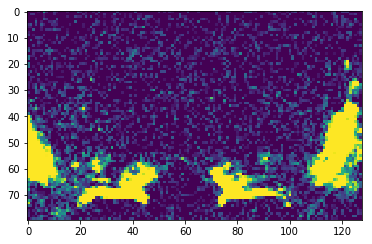

In [149]:
plt.imshow(scores,vmax=.01)
plt.show()

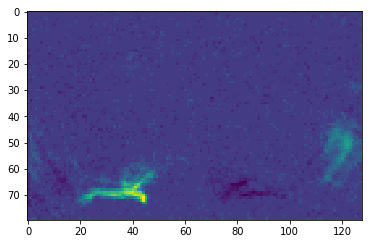

In [167]:
plt.imshow(betas[:,:,1])
plt.show()

##### Method 2 - Calculate direction betas individually

In [15]:
# Alternative method - fit separately on each direction
betas = []
scores = []

for i in range(4):
    stim01 = make_01_vector(unique_stimuli[i]['times'], resolution, expt_len)
    X = np.reshape(convolve(stim01, canonical_resp), (-1,1))
    X = X[:len(stim01),:]
    for z in tqdm(range(np.shape(brain)[2])):
        timestamps_interp, brain_interp = interp_data(brain,resolution,z,expt_len)
        for w in range(np.shape(brain)[0]):
            for h in range(np.shape(brain)[1]):
                Y = brain_interp[w,h,:]
                model = LassoLarsIC(criterion='bic')
                model.fit(X, Y)
                betas.append(model.coef_)
                scores.append(model.score(X,Y))

100%|██████████| 51/51 [39:56<00:00, 47.02s/it]


In [16]:
scores2 = np.reshape(scores, (4,51,129,80))

In [17]:
scores2 = np.swapaxes(scores2,0,2)
scores2 = np.swapaxes(scores2,1,3)

In [18]:
os.mkdir(os.path.join(directory, 'cshl_glm'))

In [19]:
for i in range(4):
    file = os.path.join(directory, 'cshl_glm', '20190721_{}.nii'.format(i))
    bbb.save_brain(file, scores2[:,:,i,:])


~~ save_brain ~~
Current memory usage: 21.44GB
save_brain done. Duration: 13.73 ms

~~ save_brain ~~
Current memory usage: 21.44GB
save_brain done. Duration: 6.78 ms

~~ save_brain ~~
Current memory usage: 21.44GB
save_brain done. Duration: 7.00 ms

~~ save_brain ~~
Current memory usage: 21.44GB
save_brain done. Duration: 6.45 ms


In [34]:
np.shape(scores2)

(128, 80, 4, 47)

In [33]:
scores2 = np.swapaxes(scores2,1,2)

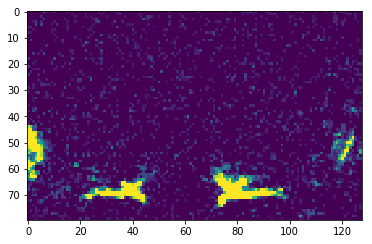

In [27]:
plt.imshow(scores2[2,17,:,:],vmax=.01)
plt.show()

In [36]:
bbb.save_brain?

In [ ]:
#X2 = np.tile(X2,(1,brain.height*brain.width))

In [ ]:
dir_betas=[]

for w in tqdm(range(brain.width)):
    for h in range(brain.height):
        Y = brain_interp[h,w,:]
        results = sl.lstsq(X2, Y)
        dir_betas.append(results[0])
        
dir_betas = np.reshape(dir_betas,(brain.width,brain.height,4))
dir_betas = np.swapaxes(dir_betas,0,1)

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle('first half of data')
plt.subplot(221)
plt.imshow(dir_betas[:,:,0],cmap='inferno')
plt.subplot(222)
plt.imshow(dir_betas[:,:,1],cmap='inferno')
plt.subplot(223)
plt.imshow(dir_betas[:,:,2],cmap='inferno')
plt.subplot(224)
plt.imshow(dir_betas[:,:,3],cmap='inferno')

###### Calculate R2

In [ ]:
r2s = []
predictions = []
for h in tqdm(range(brain.height)):
    for w in range(brain.width):
        predict = {}
        for i, direction in enumerate(directions):
            predict[direction] = np.convolve(stimtimes01_dir[direction],canonical_resp*dir_betas[h,w,i])
            predict[direction] = predict[direction][:len(stimtimes01_dir[direction])]
        prediction = predict['up']+predict['right']+predict['down']+predict['left'] ##FIX QUALITY
        predictions.append(prediction) #for later visualization
        
        
        Y = brain.vol_corrected[h,w,:]
        cor = np.corrcoef(prediction, Y)
        r2 = np.power(cor[0][1],2)
        r2s.append(r2)

r2s = np.reshape(r2s,(brain.height,brain.width))
#predictions = np.reshape(predictions,(brain.height,brain.width,exp_duration)) #Put back later if was to visualize predictions

In [ ]:
fig = plt.figure(figsize=(20,10))
threshold = 0.005
plt.set_cmap('inferno')
plt.subplot(221)
plot = np.copy(dir_betas[:,:,0])
plot[np.where(r2s<threshold)]=0
plt.imshow(plot,vmax=1)

plt.subplot(222)
plot = np.copy(dir_betas[:,:,1])
plot[np.where(r2s<threshold)]=0
plt.imshow(plot,vmax=1)

plt.subplot(223)
plot = np.copy(dir_betas[:,:,2])
plot[np.where(r2s<threshold)]=0
plt.imshow(plot,vmax=1)

plt.subplot(224)
plot = np.copy(dir_betas[:,:,3])
plot[np.where(r2s<threshold)]=0
plt.imshow(plot,vmax=1)

###### Calculate R2 for individual directions instead of pooling

In [ ]:
r2s_dir = {}

for i, direction in enumerate(directions):
    r2s_dir[direction] = []
    for h in tqdm(range(brain.height)):
        for w in range(brain.width):
            prediction = np.convolve(stimtimes01_dir[direction],canonical_resp*dir_betas[h,w,i])
            prediction = prediction[:len(stimtimes01_dir[direction])]
            Y = brain.vol_corrected[h,w,:]
            cor = np.corrcoef(prediction, Y)
            r2 = np.power(cor[0][1],2)
            r2s_dir[direction].append(r2)
    r2s_dir[direction] = np.reshape(r2s_dir[direction],(brain.height,brain.width))

In [ ]:
fig = plt.figure(figsize = (20,10))
threshold = 0.008
plt.set_cmap('inferno')
#plt.suptitle('second 5 min')

for i, direction in enumerate(directions):
    plt.subplot(2,2,i+1)
    plot = np.copy(dir_betas[:,:,i])
    plot[np.where(r2s_dir[direction]<threshold)]=0
    plt.imshow(plot,vmin=-.5,vmax=1)
    plt.colorbar()